In [1]:
import os
import numpy as np
import pandas as pd
import importlib
from psifr import fr
from cfr import framework

model_dir = '/Users/morton/Dropbox/work/cmr_cfr/cfr'
data_file = os.path.join(model_dir, 'cfr_mixed_eeg.csv')
patterns_file = os.path.join(model_dir, 'cfr_patterns.hdf5')
fit_dir = os.path.join(model_dir, 'fits', 'v3')
fig_dir = '/Users/morton/manuscripts/cfr/figs/cfr'
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)

## Load model fits

In [2]:
components = ['loc', 'cat', 'use', 'loc-cat', 'loc-use', 'cat-use', 'loc-cat-use']
models = [f'cmr_fcf-{comp}' for comp in components]
model_names = ['I', 'C', 'S', 'IC', 'IS', 'CS', 'ICS']
res = framework.read_model_fits(fit_dir, models, model_names)
res

rep  Afc  Acf  Aff  Dff    T     w_loc       Lfc       Lcf  \
model subject                                                               
I     1          2  0.0  0.0  0.0  1.0  0.1  1.000000  0.188871  0.088508   
      2          1  0.0  0.0  0.0  1.0  0.1  1.000000  0.139566  0.132066   
      3          1  0.0  0.0  0.0  1.0  0.1  1.000000  0.084998  0.061301   
      5          0  0.0  0.0  0.0  1.0  0.1  1.000000  0.175249  0.163557   
      8          2  0.0  0.0  0.0  1.0  0.1  1.000000  0.115344  0.032042   
...            ...  ...  ...  ...  ...  ...       ...       ...       ...   
ICS   42         2  0.0  0.0  0.0  1.0  0.1  0.999234  0.083212  0.049110   
      43         2  0.0  0.0  0.0  1.0  0.1  0.797397  0.097041  0.057408   
      44         2  0.0  0.0  0.0  1.0  0.1  0.862706  0.081935  0.055764   
      45         0  0.0  0.0  0.0  1.0  0.1  0.831107  0.056822  0.051909   
      46         1  0.0  0.0  0.0  1.0  0.1  0.823920  0.170028  0.160188   

                     P1  ...        X2       Dfc       Dcf         logl  \
model subject            ...                                              
I     1        0.186258  ...  0.262238  0.811129  0.911492  -899.540087   
      2        0.294150  ...  0.405579  0.860434  0.867934 -1014.021228   
      3        0.941383  ...  0.307451  0.915002  0.938699  -927.932940   
      5        0.080227  ...  0.317149  0.824751  0.836443 -1218.473199   
      8        0.086330  ...  0.311236  0.884656  0.967958  -784.548449   
...                 ...  ...       ...       ...       ...          ...   
ICS   42       0.304984  ...  0.261335  0.916788  0.950890  -742.048291   
      43       0.088308  ...  0.422599  0.902959  0.942592 -1021.821807   
      44       0.342387  ...  0.335565  0.918065  0.944236  -876.401697   
      45       0.070586  ...  0.219379  0.943178  0.948091  -921.667211   
      46       0.000000  ...  0.435564  0.829972  0.839812  -996.314451   

                   n     k     w_cat     w_use        w0        w1  
model subject                                                       
I     1        373.0   9.0       NaN       NaN       NaN       NaN  
      2        426.0   9.0       NaN       NaN       NaN       NaN  
      3        379.0   9.0       NaN       NaN       NaN       NaN  
      5        517.0   9.0       NaN       NaN       NaN       NaN  
      8        320.0   9.0       NaN       NaN       NaN       NaN  
...              ...   ...       ...       ...       ...       ...  
ICS   42       311.0  11.0  0.000766  0.376365  0.999234  0.376365  
      43       428.0  11.0  0.202603  0.289533  0.797397  0.289533  
      44       352.0  11.0  0.137294  0.124101  0.862706  0.124101  
      45       374.0  11.0  0.168893  0.083445  0.831107  0.083445  
      46       430.0  11.0  0.176080  0.155765  0.823920  0.155765  

[203 rows x 25 columns]

## Calculate AIC weights

In [3]:
res['aic'] = framework.aic(res['logl'], res['n'], res['k'])
aic = res.reset_index().pivot(index='subject', columns='model', values='aic')
aic = aic.reindex(columns=model_names)
waic = aic.copy()
waic.iloc[:, :] = framework.waic(aic.to_numpy())

In [25]:
c0 = np.array(sns.color_palette()[0])
c0

array([0.12156863, 0.46666667, 0.70588235])

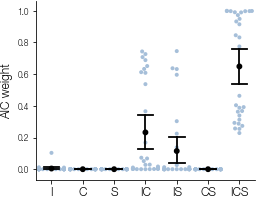

In [34]:
import importlib
import seaborn as sns
importlib.reload(sns)
importlib.reload(fr)
c = [.65, .75, .85]
df = waic.reset_index().melt(id_vars='subject', value_name='waic')
g = fr.plot_swarm_error(df, x='model', y='waic', height=3, aspect=1.2,
                        swarm_color=c, swarm_size=4)
g.set(ylabel='AIC weight');
g.axes[0, 0].tick_params(axis='x', labelsize='large')
g.savefig(os.path.join(fig_dir, 'waic.pdf'))

## Create a parameter table

In [5]:
df = framework.read_model_specs(fit_dir, models, model_names)
free_param = df.reset_index().query("kind == 'free'")['param'].unique()

In [6]:
table = pd.DataFrame(index=free_param, columns=model_names)
model_stats = res.groupby('model').agg(['mean', 'sem'])
stop = ['rep', 'n', 'k', 'w0', 'w1', 'logl', 'aic']
fields = [col for col in res.columns if col not in stop]
for model in model_names:
    m = model_stats.loc[model]
    for field in free_param:
        f = m[field]
        if np.isnan(f['mean']):
            table.loc[field, model] = (f"---")
        else:
            table.loc[field, model] = f"{f['mean']:.2f} ({f['sem']:.2f})"
table

,I,C,S,IC,IS,CS,ICS
Lfc,0.13 (0.01),0.75 (0.01),0.60 (0.04),0.12 (0.01),0.15 (0.01),0.67 (0.02),0.13 (0.01)
Lcf,0.11 (0.01),0.80 (0.01),0.68 (0.02),0.11 (0.01),0.13 (0.01),0.70 (0.01),0.11 (0.01)
P1,0.27 (0.07),0.08 (0.01),0.28 (0.05),0.22 (0.05),0.21 (0.05),0.14 (0.03),0.23 (0.05)
P2,0.95 (0.15),0.41 (0.03),0.51 (0.08),1.73 (0.24),1.57 (0.25),0.38 (0.04),1.84 (0.27)
B_enc,0.72 (0.02),0.04 (0.00),0.14 (0.03),0.64 (0.02),0.67 (0.02),0.07 (0.02),0.60 (0.02)
B_start,0.67 (0.07),0.00 (0.00),0.06 (0.02),0.54 (0.08),0.63 (0.07),0.02 (0.01),0.48 (0.08)
B_rec,0.79 (0.02),0.96 (0.01),0.81 (0.06),0.90 (0.02),0.85 (0.02),0.93 (0.03),0.90 (0.02)
X1,0.01 (0.00),0.01 (0.00),0.01 (0.00),0.01 (0.00),0.01 (0.00),0.01 (0.00),0.01 (0.00)
X2,0.31 (0.01),0.31 (0.01),0.31 (0.01),0.31 (0.01),0.31 (0.01),0.31 (0.01),0.31 (0.01)
w0,---,---,---,0.81 (0.01),0.70 (0.01),0.44 (0.03),0.84 (0.01)


In [7]:
total = res[['logl', 'n', 'k']].groupby('model').sum()
total = total.astype({'n': int, 'k': int})
total['aic'] = framework.aic(total['logl'], total['n'], total['k'])
total['waic'] = framework.waic(total['aic'].to_numpy(), 0)
output = pd.concat((table, total.T), axis=0)

In [8]:
latex_names = {
    'Lfc': 'L_{FC}',
    'Lcf': 'L_{CF}',
    'P1': 'P_1',
    'P2': 'P_2',
    'B_enc': r'\beta_{\mathrm{enc}}',
    'B_start': r'\beta_{\mathrm{start}}',
    'B_rec': r'\beta_{\mathrm{rec}}',
    'X1': 'X_1',
    'X2': 'X_2',
    'w0': 'w_1',
    'w1': 'w_2'
}
index = []
for row in output.index:
    if row in latex_names:
        name = latex_names[row]
    else:
        name = row
    index.append(name)
output.index = index
output.to_latex(os.path.join(fig_dir, 'parameters.tex'), escape=False)